In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kde import kernel_switch, bandwidths, kdensity, KDEUnivariate
from bisect import bisect_left
from scipy.stats import norm, gumbel_r, weibull_min, invweibull
from sklearn.neighbors import KernelDensity
from scipy.special import erfinv

# Task 1

### 1.1

In [12]:
rt_data = pd.read_csv('RTdata.csv', index_col=0)
samples = rt_data['rt1'].values

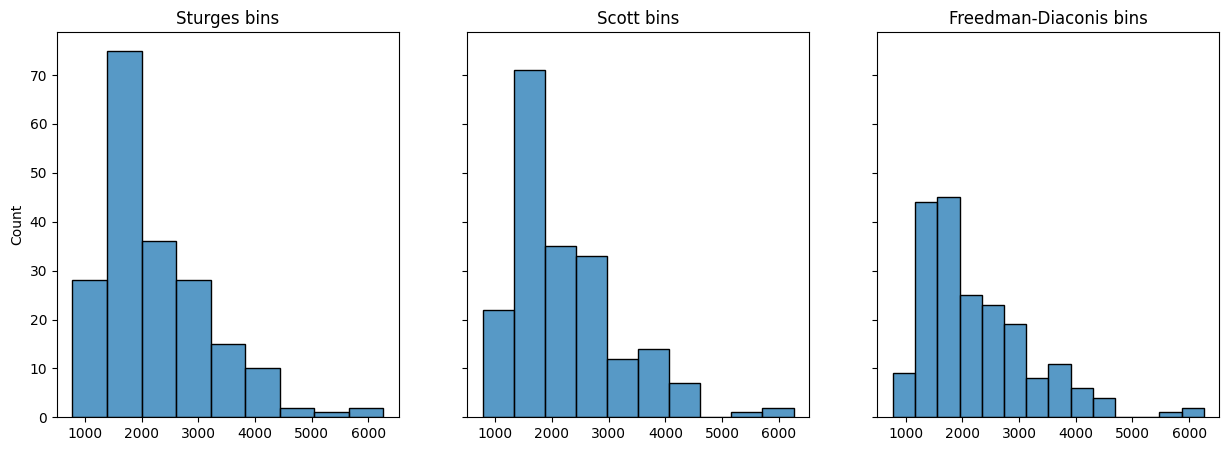

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.histplot(data=samples, bins='sturges', ax=axes[0])
axes[0].set_title('Sturges bins')
sns.histplot(data=samples, bins='scott', ax=axes[1])
axes[1].set_title('Scott bins')
sns.histplot(data=samples, bins='fd', ax=axes[2])
axes[2].set_title('Freedman-Diaconis bins')

plt.show()

### 1.2

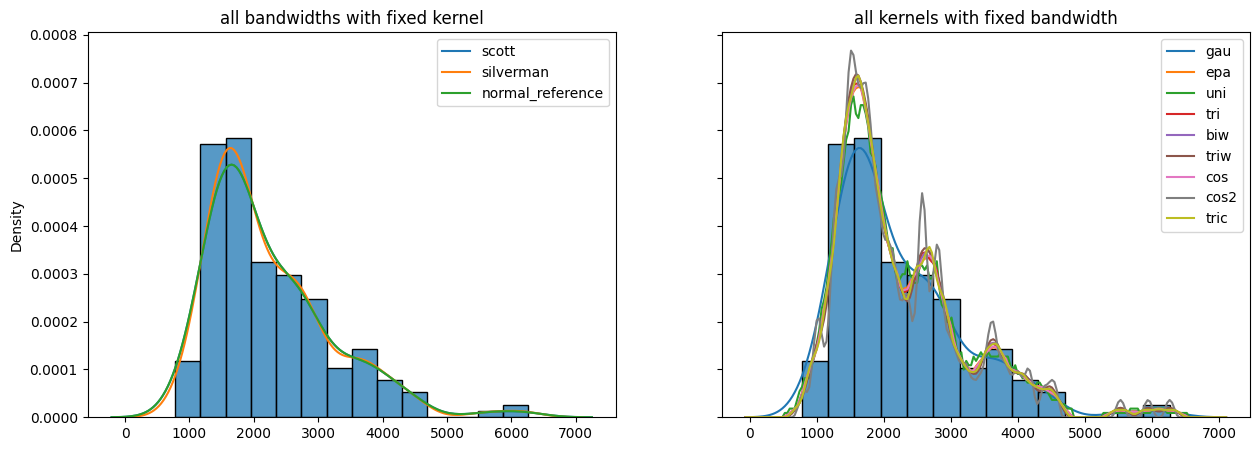

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

for bw_name in bandwidths.bandwidth_funcs.keys():
    density, grid, bw = kdensity(samples, kernel='gau', bw=bw_name)
    axes[0].plot(grid, density, label=bw_name)

sns.histplot(data=samples, stat='density', ax=axes[0])
axes[0].set_title('all bandwidths with fixed kernel')
axes[0].legend()

for kernel in kernel_switch.keys():
    density, grid, bw = kdensity(samples, kernel=kernel, bw='silverman')
    axes[1].plot(grid, density, label=kernel)

sns.histplot(data=samples, stat='density', ax=axes[1])
axes[1].set_title('all kernels with fixed bandwidth')
axes[1].legend()

plt.show()

### 1.3

In [125]:
prev_kde_estim = []

for bw_name in bandwidths.bandwidth_funcs.keys():
    density, grid, bw = kdensity(samples, kernel='gau', bw=bw_name)
    prev_kde_estim.append((grid, density))


for kernel in kernel_switch.keys():
    density, grid, bw = kdensity(samples, kernel=kernel, bw='silverman')
    prev_kde_estim.append((grid, density))

In [126]:
hist_estim = []
for i in range(10, 21):
    hist, bin_edges = np.histogram(samples, bins=i, density=True)
    hist_estim.append((bin_edges, hist))

In [152]:
min_loss = np.inf
kde_ind = 0
hist_ind = 0

for i, (grid, density) in enumerate(prev_kde_estim):
    for j, (bin_edges, hist) in enumerate(hist_estim):
        loss = 0
        for point, dens in zip(grid, density):
            position = bisect_left(bin_edges, point)
            position = min(max(0, position-1), len(hist)-1)
            loss += (hist[position] - dens)**2
        loss *= 10**15 # to scale all losses due to small floats
        loss //= len(grid)
        if loss < min_loss:
            min_loss = loss
            kde_ind = i
            hist_ind = j

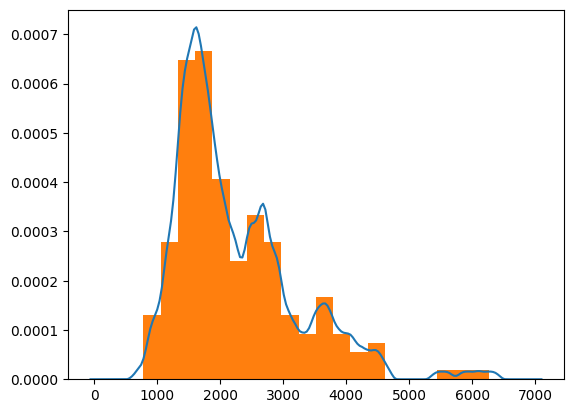

In [161]:
plt.plot(prev_kde_estim[kde_ind][0], prev_kde_estim[kde_ind][1])
plt.hist(samples, bins=hist_estim[hist_ind][0], density=True)
plt.show()

Как видно из графика, на гистограмме и kde видно несколько пиков, а еще небольшой островок справа от основной массы. Так что нетрудно предположить, что есть разные группы по скорости реакции на тест, у которых есть разное распределение - примерно по количеству пиков на графике. Примерно 3-4.

# Task 2

### 2.1

Известно, что полиномы Лагерра образуют функциональное пространство со скалярным произведением: $\langle f(x), g(x)\rangle = \int\limits_0^{\infty}f(x)g(x)e^{-x}dx$, а также, что эти полиномы ортонормированы. Используя это свойство, мы можем сказать, что любая функция на положительной оси в данном пространстве может раскладываться через полиномы Лагерра. В частности $x^j=\sum\limits_{i=0}^j \alpha_{ji}L_{i}(x)$, $\forall j \in \{0, 1, 2\}$. Тогда рассмотрим следующий интеграл:

$\int\limits_{0}^{\infty}x^jK(x)dx = \int\limits_{0}^{\infty}x^j\sum\limits_{m=0}^{2}L_m(0)L_m(x)e^{-x}dx = \int\limits_{0}^{\infty}\sum\limits_{i=0}^j \alpha_{ji}L_{i}(x)\sum\limits_{m=0}^{2}L_m(0)L_m(x)e^{-x}dx = \sum\limits_{i=0}^j\sum\limits_{m=0}^{2}\alpha_{ji}L_m(0) \int\limits_{0}^{\infty}L_{i}(x)L_m(x)e^{-x}dx$

$\int\limits_{0}^{\infty}L_{i}(x)L_m(x)e^{-x}dx = \begin{cases}1,\text{если i = m} \\ 0, \text{иначе}\end{cases}$. Также, мы рассматриваем только $j \in \{0, 1, 2\}$. Следовательно, получаем:

$\sum\limits_{i=0}^j\sum\limits_{m=0}^{2}\alpha_{ji}L_m(0) \int\limits_{0}^{\infty}L_{i}(x)L_m(x)e^{-x}dx = \sum\limits_{i=0}^j\alpha_{ji}L_i(0) = x^j|_{x=0} = \begin{cases}1,\text{если j=0} \\ 0, \text{если j=1,2}\end{cases}$

Таким образом доказано, что $K(x)$ - это ядро порядка 2.

### 2.2

$\text{AMISE}(\hat{p_n}, h) = \frac{h^4}{4}(\int_{R}(p^{''}(x))^2dx)(\int_{R}x^2K(x)dx)^2 + \frac{1}{nh}\int_{R}K^2(x)dx$

$\frac{\partial \text{AMISE}}{\partial h} = h^3(\int_{R}(p^{''}(x))^2dx)(\int_{R}x^2K(x)dx)^2 - \frac{1}{nh^2}\int_{R}K^2(x)dx = 0$

$h_{opt} = \frac{1}{n^{1/5}} (\frac{\int_{R}K^2(x)dx}{(\int_{R}(p^{''}(x))^2dx)(\int_{R}x^2K(x)dx)^2})^{1/5}$

$\text{AMISE}(\hat{p_n}, h_{opt}) = \frac{1}{4n^{4/5}} (\frac{\int_{R}K^2(x)dx}{(\int_{R}(p^{''}(x))^2dx)(\int_{R}x^2K(x)dx)^2})^{4/5}(\int_{R}(p^{''}(x))^2dx)(\int_{R}x^2K(x)dx)^2 + \frac{1}{n^{4/5}}(\frac{(\int_{R}(p^{''}(x))^2dx)(\int_{R}x^2K(x)dx)^2}{\int_{R}K^2(x)dx})^{1/5}\int_{R}K^2(x)dx = \frac{5}{4n^{4/5}}(\int_{R}(p^{''}(x))^2dx)^{1/5}(\int_{R}x^2K(x)dx)^{2/5}(\int_{R}K^2(x)dx)^{4/5}$

$K(x) = \frac{3}{4}(1-x^2)\textbf{I}(|x| < 1)$

$\int_{R}x^2K(x)dx = \frac{3}{4}\int\limits_{-1}^{1}x^2(1-x^2)dx = \frac{3}{4}\int\limits_{-1}^{1}(x^2-x^4)dx = \frac{3}{4}(\frac{x^3}{3}-\frac{x^5}{5})|_{-1}^{1} = \frac{3}{4}(1/3 - 1/5 + 1/3 - 1/5) = \frac{1}{5}$

$\int_{R}K^2(x)dx = \int\limits_{-1}^{1}\frac{9}{16}(1-x^2)^2dx = \frac{9}{16}\int\limits_{-1}^{1}1-2x^2+x^4dx = \frac{9}{16}(x -\frac{2}{3}x^3+\frac{1}{5}x^5)|_{-1}^1 = \frac{9}{16} (1 - 2/3 + 1/5 + 1 - 2/3 + 1/5) = \frac{3}{5}$

Таким образом:

$\text{AMISE}(\hat{p_n}, h_{opt}) = \frac{5}{4n^{4/5}}(\int_{R}(p^{''}(x))^2dx)^{1/5} * \frac{1}{5^{2/5}} * \frac{3^{4/5}}{5^{4/5}} = \frac{3^{4/5}}{4 * 5^{1/5} * n^{4/5}}(\int_{R}(p^{''}(x))^2dx)^{1/5}$

$\lim\limits_{n \to \infty} n^{4/5}\text{AMISE}(\hat{p_n}, h_{opt}) = \frac{3^{4/5}}{4 * 5^{1/5}}(\int_{R}(p^{''}(x))^2dx)^{1/5}$, ч.т.д.

### 2.3

$p(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{x^2}{2\sigma^2}} \to p^{'}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \frac{-x}{\sigma^2}e^{-\frac{x^2}{2\sigma^2}} \to p^{''}(x) = -\frac{1}{\sqrt{2\pi\sigma^2}} \frac{1}{\sigma^2}e^{-\frac{x^2}{2\sigma^2}} + \frac{1}{\sqrt{2\pi\sigma^2}} \frac{x^2}{\sigma^4}e^{-\frac{x^2}{2\sigma^2}}$

$\int\limits_{-\infty}^{+\infty} (p^{''}(x))^2dx = \int\limits_{-\infty}^{+\infty} (-\frac{1}{\sqrt{2\pi\sigma^2}} \frac{1}{\sigma^2}e^{-\frac{x^2}{2\sigma^2}} + \frac{1}{\sqrt{2\pi\sigma^2}} \frac{x^2}{\sigma^4}e^{-\frac{x^2}{2\sigma^2}})^2dx = \int\limits_{-\infty}^{+\infty} (\frac{1}{2\pi\sigma^2} \frac{1}{\sigma^4}e^{-\frac{x^2}{\sigma^2}} - \frac{2}{2\pi\sigma^2}\frac{x^2}{\sigma^6}e^{-\frac{x^2}{\sigma^2}} + \frac{1}{2\pi\sigma^2} \frac{x^4}{\sigma^8}e^{-\frac{x^2}{\sigma^2}})dx = \frac{1}{2\sqrt{\pi}\sigma^5}\int\limits_{-\infty}^{+\infty}\frac{1}{\sqrt{\pi\sigma^2}}e^{-\frac{x^2}{\sigma^2}}dx - \frac{1}{\sqrt{\pi}\sigma^7}\int\limits_{-\infty}^{+\infty}\frac{x^2}{\sqrt{\pi\sigma^2}}e^{-\frac{x^2}{\sigma^2}}dx + \frac{1}{2\sqrt{\pi}\sigma^9}\int\limits_{-\infty}^{+\infty}\frac{x^4}{\sqrt{\pi\sigma^2}}e^{-\frac{x^2}{\sigma^2}}dx = \frac{1}{2\sqrt{\pi}\sigma^5} - \frac{1}{\sqrt{\pi}\sigma^7} * (\frac{\sigma}{\sqrt{2}})^2 + \frac{1}{2\sqrt{\pi}\sigma^9} * (\frac{\sigma}{\sqrt{2}})^4*3 = \frac{3}{8\sqrt{\pi}\sigma^5}$

Тогда лучшая оценка для Епанечникова будет: $\frac{3^{4/5}}{4 * 5^{1/5} * n^{4/5}} (\frac{3}{8\sqrt{\pi}\sigma^5})^{1/5} = \frac{3}{2^{13/5} 5^{1/5} n^{4/5} \pi^{1/10}\sigma}$

Рассмотрим наше ядро:

$L_0(x) = \frac{e^x}{0!}x^0e^{-x} = 1$

$L_1(x) = \frac{e^x}{1!} \frac{d}{dx}(x*e^{-x}) = e^x(e^{-x} - xe^{-x}) = 1 - x$

$L_2(x) = \frac{e^x}{2!} \frac{d}{d^2x}(x^2*e^{-x}) = \frac{e^x}{2}(2xe^{-x} - x^2e^{-x})^{'} = \frac{e^x}{2}(2e^{-x} - 2xe^{-x} - 2xe^{-x} + x^2e^{-x}) = \frac{x^2}{2} - 2x + 1$

$K(x) = (1*1 + 1*(1-x) + 1*(\frac{x^2}{2} - 2x + 1))e^{-x}\textbf{I}(|x| \geq 0) = (\frac{x^2}{2} - 3x + 3)e^{-x}\textbf{I}(|x| \geq 0)$

Так как это ядро порядка 2, то оценка будет равна:

$\text{AMISE}(\hat{p_n}, h) = \frac{h^4}{4}(\int_{R}(p^{''}(x))^2dx)(\int_{R}x^2K(x)dx)^2 + \frac{1}{nh}\int_{R}K^2(x)dx = \frac{1}{nh}\int_{R}K^2(x)dx$

$\int_{R}K^2(x)dx = \int\limits_{0}^{\infty}(\frac{x^2}{2} - 3x + 3)^2e^{-2x}dx = \int\limits_{0}^{\infty}(\frac{x^4}{4} + 9x^2 + 9 - 3x^3 + 3x^2 - 18x)e^{-2x}dx = \frac{1}{2}\int\limits_{0}^{\infty}(\frac{x^4}{4} - 3x^3 + 12x^2 - 18x + 9)2e^{-2x}dx = \frac{1}{2} (\frac{1}{4}\frac{4!}{2^4} - 3\frac{3!}{2^3} + 12\frac{2!}{2^2} - 18 \frac{1!}{2} + 9) = \frac{1}{2} (\frac{6}{16} - \frac{18}{8} + \frac{24}{4} - \frac{18}{2} + 9) = \frac{33}{16}$

Чтобы при выбранном $h$ оценка с нашим ядром была лучше, чем с Епанечникова в любом случае, надо, чтобы выполнялось условие:

$\frac{1}{nh}\frac{33}{16} < \frac{3}{2^{13/5} 5^{1/5} n^{4/5} \pi^{1/10}\sigma} \to nh \frac{16}{33} > \frac{2^{13/5} 5^{1/5} n^{4/5} \pi^{1/10}\sigma}{3} \to h > \frac{11*5^{1/5}\pi^{1/10}\sigma}{n^{1/5}2^{7/5}}$

Так как $n$ минимум равен 1, то при условии $h > \frac{11*5^{1/5}\pi^{1/10}\sigma}{2^{7/5}}$, оценка с нашим ядром будет лучше.

### 2.4

In [133]:
sigma = 1
n = 1000
M = 1000
samples = norm.rvs(loc=0, scale=sigma, size=n)
bws = np.arange(0.1, 5.1, 0.1)

In [142]:
def custom_kernel(x):
    mask_1 = np.isclose(x, 0)
    mask_2 = ~mask_1 * x < 0
    res = (x**2 / 2 - 3*x + 3) * np.exp(-x)
    res[mask_1] = 3
    res[mask_2] = 0
    return res 

def epanechnikov_kernel(x):
    mask = abs(x) >= 1
    res = 3/4 * (1-x**2)
    res[mask] = 0
    return res

In [143]:
points = np.linspace(-3, 3, M, endpoint=True)
points_true_density = norm.pdf(points, loc=0, scale=sigma)

In [164]:
custom_losses = []
epanechnikov_losses = []
pair_wise_diffs = points.reshape(-1, 1) - samples
for bw in bws:
    custom_density = custom_kernel(pair_wise_diffs / bw).sum(axis=1) / (n*bw)
    epa_density = epanechnikov_kernel(pair_wise_diffs / bw).sum(axis=1) / (n*bw)
    custom_losses.append(np.mean((custom_density - points_true_density)**2))
    epanechnikov_losses.append(np.mean((epa_density - points_true_density)**2))

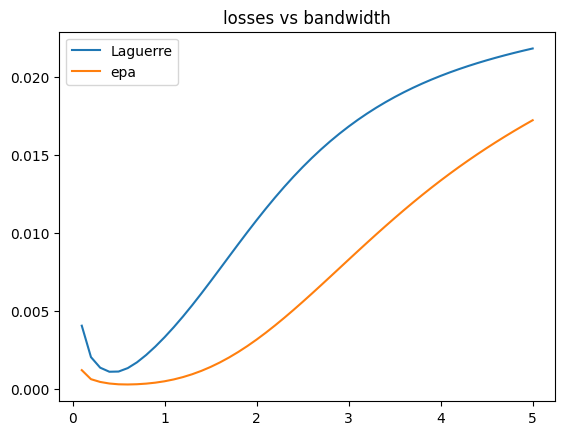

In [165]:
plt.plot(bws, custom_losses, label='Laguerre')
plt.plot(bws, epanechnikov_losses, label='epa')

plt.title('losses vs bandwidth')
plt.legend()
plt.show()

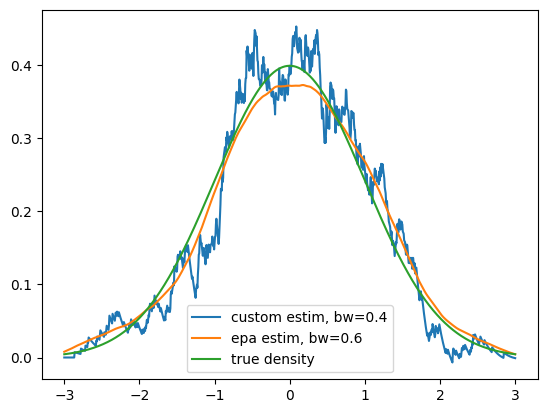

In [166]:
best_custom_ind = np.argmin(custom_losses)
best_epa_ind = np.argmin(epanechnikov_losses)

custom_density = custom_kernel(pair_wise_diffs / bws[best_custom_ind]).sum(axis=1) / (n*bws[best_custom_ind])
epa_density = epanechnikov_kernel(pair_wise_diffs / bws[best_epa_ind]).sum(axis=1) / (n*bws[best_epa_ind])

plt.plot(points, custom_density, label=f'custom estim, bw={bws[best_custom_ind]}')
plt.plot(points, epa_density, label=f'epa estim, bw={bws[best_epa_ind]}')
plt.plot(points, points_true_density, label='true density')
plt.legend()
plt.show()

# Task 3

### 3.1

$\bar{F}(x) = 1 - F(x) = 1 - \int\limits_{-\infty}^{x}\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(t-\mu)^2}{2\sigma^2}}dt$

$F^{'}(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

$\lim\limits_{x\to\infty} \frac{\bar{F}(x)}{\frac{1}{x}F^{'}(x)} = \lim\limits_{x\to\infty} \frac{1 - \int\limits_{-\infty}^{x}\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(t-\mu)^2}{2\sigma^2}}dt}{\frac{1}{x}\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}}$ = {Правило Лопиталя} = $\lim\limits_{x\to\infty}\frac{-\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}}{-\frac{1}{x^2}\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} + \frac{1}{x}\frac{1}{\sqrt{2\pi\sigma^2}}\frac{\mu-x}{\sigma^2}e^{-\frac{(x-\mu)^2}{2\sigma^2}}} = \lim\limits_{x\to\infty} \frac{-\frac{1}{\sqrt{2\pi\sigma^2}}}{-\frac{1}{x^2}\frac{1}{\sqrt{2\pi\sigma^2}} + \frac{1}{x}\frac{1}{\sqrt{2\pi\sigma^2}}\frac{\mu-x}{\sigma^2}} = \lim\limits_{x\to\infty} \frac{-\frac{1}{\sqrt{2\pi\sigma^2}}}{-\frac{1}{\sigma^2\sqrt{2\pi\sigma^2}}} = \sigma^2 = $ константа. Таким образом, можно утверждать, что $\bar{F}(x) \sim F^{'}(x)x^{-1}$

Для нормального распределения $x_F >> \mu$, а точнее $x_F=+\infty$. Как известно, производная нормального распредления неотрицательна: $\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} > 0$  $\forall x$. Рассмотрим вторую производную, найденную на предыдущем шаге:

$F^{''}(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\frac{\mu-x}{\sigma^2}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

Здесь $\frac{1}{\sqrt{2\pi\sigma^2}} > 0$, $\sigma^2 > 0$, $e^{-\frac{(x-\mu)^2}{2\sigma^2}} > 0$, а $\mu-x < 0\ \forall x \in (y, x_F)$, если взять $\mu < y < x_F$. Таким образом, условия для утверждения выполнены. Проверим сам критерий:

$\lim\limits_{x\to\infty} \frac{\bar{F}(x) F^{''}(x)}{(F^{'}(x))^2} = \lim\limits_{x\to\infty} \frac{\sigma^2 \frac{F^{'}(x)}{x} F^{''}(x)}{(F^{'}(x))^2} = \sigma^2 \lim\limits_{x\to\infty} \frac{F^{''}(x)}{xF^{'}(x)} = \sigma^2 \lim\limits_{x\to\infty} \frac{\frac{1}{\sqrt{2\pi\sigma^2}}\frac{\mu-x}{\sigma^2}e^{-\frac{(x-\mu)^2}{2\sigma^2}}}{x\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}} = \lim\limits_{x\to\infty} \frac{\mu-x}{x} = -1$

Утверждение 1 выполнено для нормального распределения. То есть максимальные значения данного распределения имеют распределение Гумбеля.

### 3.2

$g(x) = \sqrt{\frac{2}{\pi}}e^{-x^2/2}\textbf{I}(x > 0) > 0$

$G(x) = \int\limits_{0}^{x}\sqrt{\frac{2}{\pi}}e^{-t^2/2}dt = \frac{2}{\sqrt{\pi}}\int\limits_{0}^{x}e^{-t^2/2}d\frac{t}{\sqrt{2}} = \frac{2}{\sqrt{\pi}}\int\limits_{0}^{x/\sqrt{2}}e^{-s^2}ds = erf(\frac{x}{\sqrt{2}}), \bar{G}(x) = erfc(\frac{x}{\sqrt{2}})$

$G^{''}(x) = g^{'}(x) = -x\sqrt{\frac{2}{\pi}}e^{-x^2/2} < 0$

Условия подходят для утверждения 1. проверим критерий при $x_F = \infty$:

$\lim\limits_{x\to\infty} \frac{\bar{G}(x)G^{''}(x)}{(G^{'}(x))^2} = \lim\limits_{x\to\infty} \frac{-erfc(\frac{x}{\sqrt{2}}) * x\sqrt{\frac{2}{\pi}}e^{-x^2/2}}{\frac{2}{\pi}e^{-x^2}} = \lim\limits_{x\to\infty} \frac{-erfc(\frac{x}{\sqrt{2}})}{\frac{1}{x}\sqrt{\frac{2}{\pi}}e^{-x^2/2}}$

Ассимптотика erfc: $erfc(x) = \frac{e^{-x^2}}{x\sqrt{\pi}}$ при $x \to \infty$. Таким образом:

$\lim\limits_{x\to\infty} \frac{-erfc(\frac{x}{\sqrt{2}})}{\frac{1}{x}\sqrt{\frac{2}{\pi}}e^{-x^2/2}} = \lim\limits_{x\to\infty} \frac{-\frac{e^{-x^2/2}}{x\frac{\sqrt{\pi}}{\sqrt{2}}}}{\frac{1}{x}\sqrt{\frac{2}{\pi}}e^{-x^2/2}} = -1$

И распределение имеет MDA Гумбеля.

In [29]:
n = 1000
u_vec = np.random.uniform(0, 1, size=n)
samples = 2**0.5*erfinv(u_vec)

In [30]:
samples_sorted = np.sort(samples)

In [31]:
def hill(k, sort_samples):
    return np.sum(np.log(sort_samples[-(k-1):] / sort_samples[-k])) / (k - 1)

def DAH(k, samples):
    H_1 = np.mean(np.log(samples[-k:]) - np.log(samples[-k-1]))
    H_2 = np.mean((np.log(samples[-k:]) - np.log(samples[-k-1]))**2)
    return 1 + H_1 + 0.5 / (H_1**2 / H_2 - 1)

def Pickands(k, samples):
    return np.log((samples[-k] - samples[-2*k]) / (samples[-2*k] - samples[-4*k])) / np.log(2)

In [32]:
ks = np.arange(2, 220, 1)
hill_est = []
DAH_est = []
pick_est = []
for k in ks:
    hill_est.append(hill(k, samples_sorted))
    DAH_est.append(DAH(k, samples_sorted))
    pick_est.append(Pickands(k, samples_sorted))

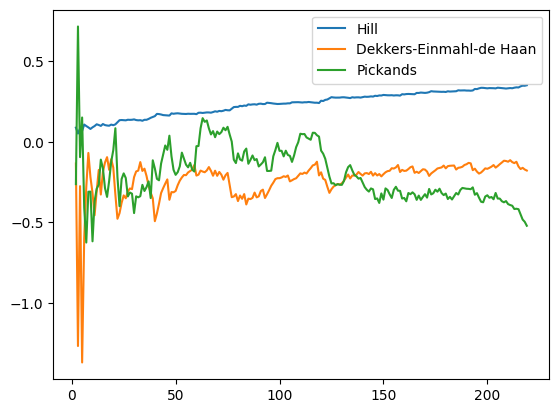

In [33]:
plt.plot(ks, hill_est, label='Hill')
plt.plot(ks, DAH_est, label='Dekkers-Einmahl-de Haan')
plt.plot(ks, pick_est, label='Pickands')

plt.legend()
plt.show()

In [14]:
u_mat = np.random.uniform(0, 1, size=(n, n))
samples_batch = 2**0.5*erfinv(u_mat)
max_stats = np.max(samples_batch, axis=1)

In [19]:
frechet_samples = invweibull.rvs(loc=0, scale=1, c=2, size=n)
weibull_samples = weibull_min.rvs(loc=0, scale=1, c=2, size=n)
gumbell_samples = gumbel_r.rvs(loc=0, scale=1, size=n)

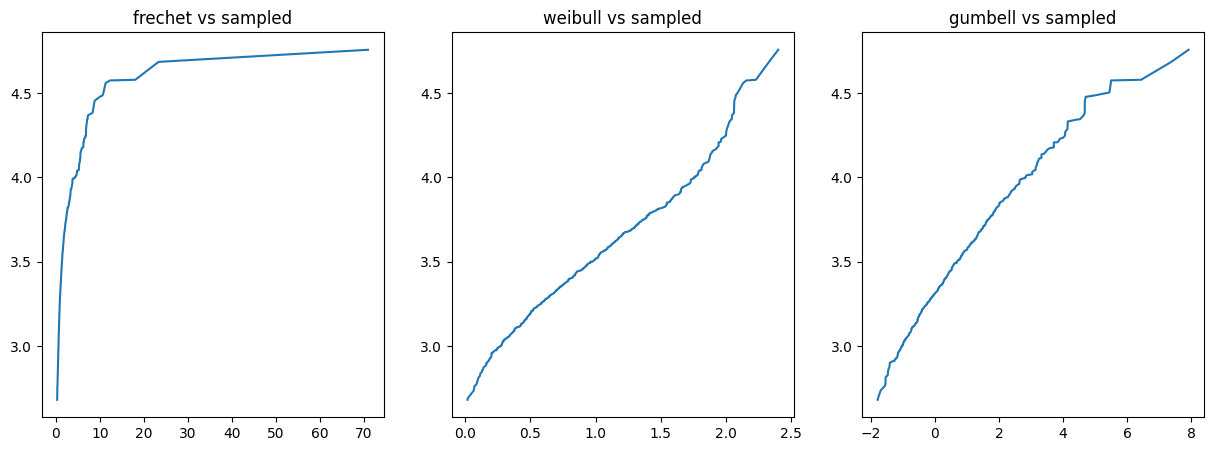

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(np.sort(frechet_samples), np.sort(max_stats))
axes[0].set_title('frechet vs sampled')
axes[1].plot(np.sort(weibull_samples), np.sort(max_stats))
axes[1].set_title('weibull vs sampled')
axes[2].plot(np.sort(gumbell_samples), np.sort(max_stats))
axes[2].set_title('gumbell vs sampled')

plt.show()

Вейбул и Гумбель кандидаты на MDA, теоретически должен быть Гумбель.

# Task 4

### 4.1

### 4.2

$p(x) = e^{-(\theta-x)}\textbf{I}(x \leq \theta)$

$E(x) = \int\limits_{-\infty}^{\theta}xe^{-(\theta-x)}dx = e^{-\theta}\int\limits_{-\infty}^{\theta}xe^{x}dx = e^{-\theta}\int\limits_{-\infty}^{\theta}xde^x = e^{-\theta}(xe^x|_{-\infty}^{\theta} - \int\limits_{-\infty}^{\theta}e^xdx) = e^{-\theta}(\theta e^{\theta} - e^{\theta}) = \theta - 1$

$E(x^2) = \int\limits_{-\infty}^{\theta}x^2e^{-(\theta-x)}dx = e^{-\theta} \int\limits_{-\infty}^{\theta}x^2de^x = e^{-\theta} (x^2e^x|_{-\infty}^{\theta} -2\int\limits_{-\infty}^{\theta}xe^xdx) = e^{-\theta} (\theta^2e^{\theta} - 2(\theta e^{\theta} - e^{\theta})) = \theta^2 - 2\theta + 2$

Ассимптотический интервал:

$P(-z_{1-\alpha/2} \leq \frac{\sqrt{n}(\bar{x} - \theta + 1)}{\sqrt{\theta^2 - 2\theta + 2}}\leq z_{1-\alpha/2}) = 1-\alpha$

Дисперсию сложно посчитать, заменим ее на $X_{(n)}^2 - 2X_{(n)} + 2$

$P(-z_{1-\alpha/2} \leq \frac{\sqrt{n}(\bar{x} - \theta + 1)}{\sqrt{X_{(n)}^2 - 2X_{(n)} + 2}}\leq z_{1-\alpha/2}) \to P(-z_{1-\alpha/2} \sqrt{\frac{X_{(n)}^2 - 2X_{(n)} + 2}{n}} \leq \bar{x} - \theta + 1 \leq z_{1-\alpha/2} \sqrt{\frac{X_{(n)}^2 - 2X_{(n)} + 2}{n}}) \to P(z_{1-\alpha/2} \sqrt{\frac{X_{(n)}^2 - 2X_{(n)} + 2}{n}} + \bar{x} + 1\geq  \theta \geq -z_{1-\alpha/2} \sqrt{\frac{X_{(n)}^2 - 2X_{(n)} + 2}{n}} +\bar{x} + 1)$

Асимптотический доверителный интервал: $(-z_{1-\alpha/2} \sqrt{\frac{X_{(n)}^2 - 2X_{(n)} + 2}{n}} +\bar{x} + 1, z_{1-\alpha/2} \sqrt{\frac{X_{(n)}^2 - 2X_{(n)} + 2}{n}} + \bar{x} + 1)$


Точный интервал:

$P(-t_{1-\alpha / 2, n-1} \leq \frac{\sqrt{n-1} (\bar{x} - \theta + 1)}{s}\leq t_{1-\alpha / 2, n-1})$,

где $s = \sqrt{\frac{1}{n-1}\sum(x_k - x)^2}$, $\bar{x} = \frac{1}{n} \sum x_k$

$P(-\frac{s}{\sqrt{n-1}}*t_{1-\alpha / 2, n-1} \leq \bar{x} - \theta + 1 \leq \frac{s}{\sqrt{n-1}}*t_{1-\alpha / 2, n-1}) = P(- \frac{s}{\sqrt{n-1}}*t_{1-\alpha / 2, n-1} - \bar{x} - 1 \leq  - \theta \leq \frac{s}{\sqrt{n-1}}*t_{1-\alpha / 2, n-1} - \bar{x} - 1) = P( \frac{s}{\sqrt{n-1}}*t_{1-\alpha / 2, n-1} + \bar{x} + 1 \geq \theta \geq -\frac{s}{\sqrt{n-1}}*t_{1-\alpha / 2, n-1} + \bar{x} + 1)$

Точный интервал: $(\bar{x} + 1 -\frac{s}{\sqrt{n-1}}*t_{1-\alpha / 2, n-1}, \bar{x} + 1 +\frac{s}{\sqrt{n-1}}*t_{1-\alpha / 2, n-1})$